In [411]:
from IPython.core.display import HTML
#HTML("""
#<style>
#.output_png {
    #display: table-cell;
    #text-align: center;
    #vertical-align: middle;
#}
#</style>
#""")

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.signal import convolve2d

# plot helpers
def setplot(p):
    p.axes.xaxis.set_ticks([])
    p.axes.yaxis.set_ticks([])

transparent = clr.colorConverter.to_rgba('white',alpha=0)
grow = clr.ListedColormap([transparent,'green'])
dense = clr.ListedColormap([transparent,'firebrick'])
diffuse = clr.ListedColormap([transparent,'lightcoral'])
persist = clr.ListedColormap([transparent,'grey'])
        
def plotforward(num_board, showfast=False):
    
    # count neighbors
    # https://nicholasrui.com/2017/12/18/convolutions-and-the-game-of-life/
    neigh = np.ones((3,3))
    neigh[1][1] = 0
    neighbors = convolve2d(num_board, neigh, mode='same', boundary='wrap')
    board = (num_board == 1)
    
    # apply rules
    underpop = (neighbors < 2) & board
    survive = np.vectorize(lambda x: 2 <= x <= 3)(neighbors) & board
    overpop = (neighbors > 3) & board
    newgrow = (neighbors == 3) & ~board
    nextboard = newgrow | survive

    # plot it
    fig, plot = plt.subplots(1, 3, figsize=(10,15))
    for p in plot:
        setplot(p)
    plot[0].imshow(board, cmap='binary')
    plot[1].imshow(underpop, cmap=diffuse)
    plot[1].imshow(newgrow, cmap=grow)
    plot[1].imshow(survive, cmap=persist)
    plot[1].imshow(overpop, cmap=dense)
    plot[2].imshow(nextboard, cmap='binary')
    
    if showfast:

        # same thing, but fewer intermediary steps
        cell_ct = np.ones((3,3))
        cells = convolve2d(num_board, cell_ct, mode='same', boundary='wrap')
        fastnext = (cells == 3) | (board & (cells == 4))
        
        # plot it
        fig, plot = plt.subplots(1, 1, figsize=(3,3))
        setplot([plot])
        plot.imshow(fastnext, cmap='binary')
    
    return np.vectorize(lambda x: {True : 1, False: 0}[x])(nextboard)

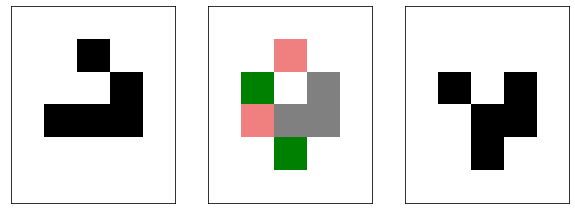

In [413]:
start = np.zeros((6,5))
start[1][2] = 1
start[2][3] = 1
start[3][1] = 1
start[3][2] = 1
start[3][3] = 1

middle = plotforward(start)

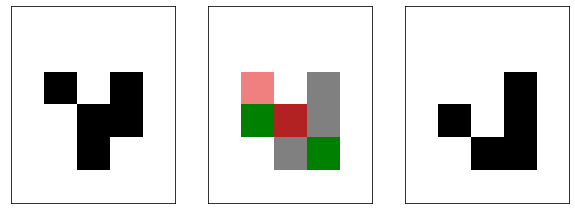

In [414]:
end = plotforward(middle)

In [415]:
import itertools
from math import ceil
from pprint import pprint
from sortedcontainers import SortedDict
from matplotlib.colors import ListedColormap
from IPython.display import display, Math, Latex

bluish = clr.colorConverter.to_rgba('cornflowerblue',alpha=0.4)
purplish = clr.colorConverter.to_rgba('darkorchid',alpha=0.6)

inscope = clr.ListedColormap([transparent,bluish])
targeted = clr.ListedColormap([transparent,purplish])
lightgray = clr.ListedColormap(['white','lightgray'])

    
def storyboard(board, zoom=[]):
    summary = []     # the current arc
    plan = []        # the whole story
    
    # decide which cells to summarize and which to show details for
    max_x = board.shape[1] - 1
    max_y = board.shape[0] - 1
    for y, rows in enumerate(board):
        for x, cell in enumerate(rows):
            summary.append((x, y))
            if (x,y) in zoom:
                plan.append(summary)
                plan.append((x,y))
                summary = []
            if (x == max_x and y == max_y):
                plan.append(summary)
                summary = []
    return plan

To run Life backwards we ask:
> Given that this cell is alive/dead at $t$, what could it and its neighbors have been at $t-1$ ?

Well, that would be the straightforward thing to do.
But for some technical reasons that I'll discuss in a bit, we'll actually be asking:
> Which neighbors could **not** have been alive at $t-1$

In our 5x6 grid there are 30 cells to examine.
We'll need a unique name for each one, so let's number them from top left to bottom right.

For each of these, let's get these exclusions of neighbor behavior in terms of their neighbor's numbers.
We'll use `-x` to refer to a dead neighbor, and `x` to refer to a living neighbor.

In [416]:
scenes = storyboard(end, zoom=[(3,1),(1,3)])
arc1 = scenes[0]
example1 = scenes[1]
arc2 = scenes[2]
example2 = scenes[3]
arc3 = scenes[4]

In [417]:
# -1 and 1 for dead/alive requires 1-based indexing
def cell_ref(num, board):
    width = board.shape[1]
    x = (num - 1) % width
    y = int(((num - 1 - x) / width))
    return (x, y)

# but x,y (0,0 is top-left) is handy too
def cell_num(x, y, board):
    return y * board.shape[1] + x + 1


def get_neighborhood(x, y, board):
    max_x = board.shape[1]
    max_y = board.shape[0]
    neighborhood = np.zeros((3,3))
    for oy in range(-1,2):
        for ox in range(-1,2):
            ix = (x + ox) % max_x 
            iy = (y + oy) % max_y
            neighborhood[oy + 1,ox + 1] = board[iy,ix]
    return neighborhood
            

# A neighborhood around some cell:

#  1 2 3
#  4 5 6
#  7 8 9

# use this to translate the relative cell names to coordinate offsets
# x/y coordinates have (0,0) in the upper left corner and (0,1) below that
# so -y means "up"
neighborhood_2_offset = {
    1 : (-1, -1), 2 : ( 0,-1), 3 : (1, -1),
    4 : (-1,  0), 5 : ( 0, 0), 6 : (1,  0),
    7 : (-1,  1), 8 : ( 0, 1), 9 : (1,  1)
}

def summarize(story_arc, board, overlap=False):
    
    max_x = board.shape[1]
    max_y = board.shape[0]
    
    if overlap:
        
        # just one plot
        fig, plot = plt.subplots(1, 1, figsize=(2, 2))
        setplot(plot)
        plot.imshow(board, cmap=gray)
        for x, y in story_arc:
            scope = np.zeros((max_y, max_x))
            for oy in range(-1,2):
                for ox in range(-1,2):
                    ix = (x + ox) % max_x 
                    iy = (y + oy) % max_y 
                    scope[iy, ix] = 1
            plot.imshow(scope, cmap=inscope)
        return 

    y_vals = set(c[1] for c in story_arc)
    min_y = min(y_vals)
    ct_y = len(y_vals)
    ct_x = len(board[0])
    
    include = np.zeros((ct_y, ct_x))
    for x, y in story_arc:
        include[y - min_y][x] = 1

    # layout
    plots_by_y = SortedDict()
    fig, all_plots = plt.subplots(ct_y, ct_x, figsize=(2*ct_x,2*ct_y))
    for (y,x), show in np.ndenumerate(include):
        plot = all_plots[y][x]
        setplot(plot)
        if show:   
            plots_by_y.setdefault(y + min_y, SortedDict())[x] = plot
        else:
            plot.axis('off')
            
    # plots
    for y, plots_by_x in plots_by_y.items():
        for x, plot in plots_by_x.items():
            num = cell_num(x,y,board)
            plot.title.set_text(str(num))
            scope = np.zeros((max_y, max_x))
            bullseye = np.zeros((max_y, max_x))
            
            for oy in range(-1,2):
                for ox in range(-1,2):
                    ix = (x + ox) % max_x 
                    iy = (y + oy) % max_y 
                    if oy == ox == 0:
                        bullseye[iy, ix] = 1
                    else:
                        scope[iy, ix] = 1
            plot.imshow(board, cmap=gray)
            plot.imshow(scope, cmap=inscope)
            plot.imshow(bullseye, cmap=targeted)

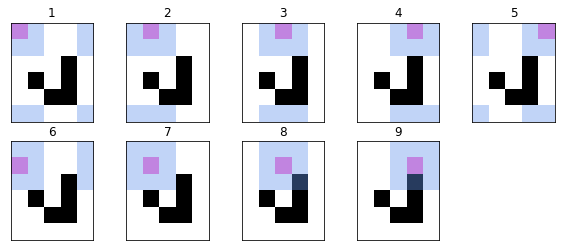

In [418]:
summarize(arc1, end)

Notice that there is a lot of overlap here.
Six of the nine cells in neighborhood 7 are also part of neighborhood 8.

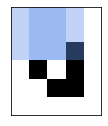

In [419]:
summarize(arc1[6:8], end, overlap=True)

Neighborhoods around dead cells have 84 possible precursor states each (more on this in a minute), but we can ignore the ones that are incompatible with the adjacent neighborhood.

Instead of carrying out compatibility check ourselves, we will express our understanding of the possible precursor states on a cell-by-cell basis, and then leave it to a SAT-solver to figure out how thosep

Let's look more closely at how this works for the neighborhood around dead cell (3,1)

In [503]:
%matplotlib inline
from IPython.core.display import display, HTML
from inspect import cleandoc
import math
transblack =  grow = clr.ListedColormap([transparent,'black'])
transwhite =  grow = clr.ListedColormap([transparent, 'white'])
transgreen =  grow = clr.ListedColormap([transparent, 'mediumspringgreen'])
gray = clr.ListedColormap(['white','black'])

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# "-x" means "x is dead"
# "x" means "x is alive"
# the following are equivalent (see: De Morgan's law)
#     -(1 and 3) and -(-7 and -9) and -(4 and -6)
#     (-1 or -3) and (7 or 9) and (-4 or 6)

# I find the former easier to think about-
# -(a list of scenarios to exclude the search for solutions)
# but SAT solvers will want the latter (conjunctive normal form)
# to express the situation above, return:
#    [[1, 3], [-7, -9], [4, -6]],

ALIVE = -1
DEAD = 1
    
def dead_precursors():
    # assuming 5 is dead, what cannot be true of the preceeding state?
    
    by_explanation = {}
    
    def add(clause):
        by_explanation.setdefault(expl, []).append(clause)
    
    palette = set(range(1,10))
    neighbors = palette - {5}

    expl = cleandoc("""
        These are the histories with exactly three living neighbors.
          - if 5 was dead, it would have triggered the growth rule and be alive now
          - if 5 was alive, it would have triggered the survive rule and be alive now

        5 is not alive, so we can exclude all of these. The center cell is omitted because they can be excluded regardless of its value.
        """)

    for three in itertools.combinations(neighbors, 3):

        alive = { ALIVE * x for x in set(three) }
        dead = { DEAD * x for x in (neighbors - {abs(x) for x in alive}) }
        clause = tuple(sorted(alive.union(dead)))
        add(clause)

    expl = cleandoc("""
        These are the histories where the center cell is alive and has exactly two living neighbors.
        They would have triggered the 'survive' rule, so we can exclude them because our center cell is dead.
        """)

    for two in itertools.combinations(neighbors, 2):

        alive = { ALIVE * x for x in set(two) }
        dead = { DEAD * x for x in (neighbors - {abs(x) for x in alive}) }
        clause = tuple(sorted(alive.union(dead).union({ALIVE * 5})))
        add(clause)
        
    return by_explanation

def alive_precursors():
    """
    assuming 5 is alive, what cannot be true of the preceeding state?
    """
    
    by_explanation = {}
    
    def add(clause):
        by_explanation.setdefault(expl, []).append(clause)
        
    palette = set(range(1,10))
    neighbors = palette - {5}
    

    expl = cleandoc(
        """
        These are the histories with four living neighbors.  They lead to a dead cell, regardless of the center cell's previous
        state, so we can leave the center cell unspecified.
        """)
    
    for four in itertools.combinations(neighbors, 4):
        alive = { ALIVE * x for x in (neighbors - set(four)) }
        clause = tuple(sorted(alive))
        add(clause)
    print("alive unspec", clause)

    expl = cleandoc(
        """
        Let's assume that the center cell was dead.  Then it must have recently grown, which requires three alive neighbors.
        Any history with six (or more) dead neighbors has only two (or fewer) alive--which is not enough to trigger the
        growth rule.
        """)
    
    for six in itertools.combinations(neighbors, 6):
        dead = { DEAD * x for x in six }.union({DEAD * 5})
        clause = tuple(sorted(dead))
        add(clause)
    print("alive dead", clause)

    expl = cleandoc(
        """
        If we assume that the center cell was alive, then it must have recently survived, which requires two or three alive 
        neighbors. Any history with seven (or more) dead neighbors had one (or fewer) living neighbor--which is not enough 
        to trigger the survive rule.
        """)

    for seven in itertools.combinations(neighbors, 7):
        # this makes sense to me
        dead = { DEAD * x for x in seven }.union({ALIVE * 5})

        # but this is what elvenmonk has, and they seem pretty smart
        #dead = { DEAD * x for x in seven }
        clause = tuple(sorted(dead))
        add(clause)
    print("alive alive", clause)
    
    return by_explanation

def global_refs(x, y, board, scenario): 
    
    excluded_history = []
    p_alive = np.zeros((3,3))
    p_dead = np.zeros((3,3))

    # translate neighborhood coords to global cell numbers
    for val in scenario:
        
        ox, oy = neighborhood_2_offset[abs(val)]

        # neighborhood coordinates
        nx = ox + 1
        ny = oy + 1

        # global coordinates
        ix = (x + ox) % board.shape[1]
        iy = (y + oy) % board.shape[0]

        # clause components
        if int(val / abs(val)) == int(ALIVE):
            p_alive[ny][nx] = 1
            ref = ALIVE * cell_num(ix, iy, board)
        else:
            p_dead[ny][nx] = 1
            ref = DEAD * cell_num(ix, iy, board)
            
        excluded_history.append(ref)

    return excluded_history, (p_alive, p_dead)


def get_excluded_histories(cell, board):
    
    x, y = cell
    global_cell_num = cell_num(x, y, board)
    neighborhood = get_neighborhood(x,y,board)
    alive = bool(neighborhood[1,1])
    
    if alive:
        precursors = alive_precursors()
    else:
        precursors = dead_precursors()
    
    excluded_histories = []
    for history_group in precursors.values():
        for scenario in history_group:
            refs, _ = global_refs(x, y, board, scenario)
            excluded_histories.append(refs)

    return excluded_histories

def tell(story, board, showexpr=False):
    
    # the setting
    x, y = story
    max_x = board.shape[1]
    max_y = board.shape[0]
    global_cell_num = cell_num(x, y, board)
    neighborhood = get_neighborhood(x,y,board)
    
    alive = bool(neighborhood[1,1])
    if alive:
        alive_msg = "alive"
    else:
        alive_msg = "dead"
    
    # two plots
    fig, plots = plt.subplots(1, 2, figsize=(4, 2))
    for plot in plots:
        setplot(plot)
    fig.text(0.15, 0.92, 
             f""" 
             Given that its center cell is {alive_msg}, which precursors can we rule out?
             
             """, ha='left', fontsize=14)
        
    # zoomed out
    plot = plots[0]
    plot.imshow(board, cmap=gray)
    scope = np.zeros((max_y, max_x))
    for oy in range(-1,2):
        for ox in range(-1,2):
            ix = (x + ox) % max_x 
            iy = (y + oy) % max_y 
            scope[iy, ix] = 1
    plot.imshow(scope, cmap=inscope)
    
    # zoomed in
    plot = plots[1]
    plot.imshow(neighborhood, cmap=gray)
    targetmask = np.zeros((3,3))
    targetmask[1,1] = 1
    c = 0
    mode = None
    for i in range(3):
        for j in range(3):
            ix = i + x - 1
            iy = j + y - 1
            label = cell_num(ix, iy, board)
            
            if neighborhood[j,i]:
                mode = 'alive'
                plot.imshow(targetmask != 0, cmap=transblack)
                plot.annotate(label,(i,j), color='w', size=14, weight="bold", ha="center", va="center")
            else:
                mode = 'dead'
                plot.imshow(targetmask != 0, cmap=transwhite)
                plot.annotate(label,(i,j), size=14, weight="bold", ha="center", va="center")
            c += 1
            
    # added clauses depend only on whether the focussed cell is alive or dead
    if neighborhood[1][1]:
        excluded_by_explanation = alive_precursors()
    else:
        excluded_by_explanation = dead_precursors()
        
    # a batch of plots for each class of excluded precursor
    for explanation, exclusion in excluded_by_explanation.items():
        
        if showexpr:
            width = 10
        else:
            width = 12
        height = math.ceil(len(exclusion) / width)
        
    
        plots = []
        if showexpr:
            fig, iplots = plt.subplots(height, width, figsize=(1.5 * width, 2 * height))
            fig.text(0.15, 0.92, explanation, ha='left', fontsize=14)
        else:
            fig, iplots = plt.subplots(height, width, figsize=(width, height))
            fig.tight_layout()
            fig.text(0.05, 1.0, explanation, ha='left', fontsize=14)
        
        for row in iplots.tolist():
            try:
                for p in row:
                    setplot(p)
                    plots.append(p)
            except TypeError:
                setplot(row)
                plots.append(row)
                
        cadence = 0
        for ex_num, scenario in enumerate(exclusion):
            
            # a tiny plot for each clause
            cadence += 1
            plot = plots[ex_num]
            
            _, (p_alive, p_dead) = global_refs(x, y, board, scenario)
            
            if showexpr:
                if (cadence % 10) in [2, 9]:
                   title = ','.join(map(str, globalref))
                   plot.title.set_text(title)
                    
            p_unspecified = np.ones((3,3)) - p_alive - p_dead
            
            plot.imshow(p_alive, cmap=transblack)
            plot.imshow(p_dead, cmap=transwhite)
            plot.imshow(p_unspecified, cmap=transgreen)
            
        for i in range(cadence, len(plots)):
            plots[i].axis('off')


<Figure size 432x288 with 0 Axes>

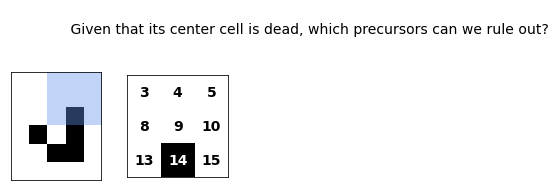

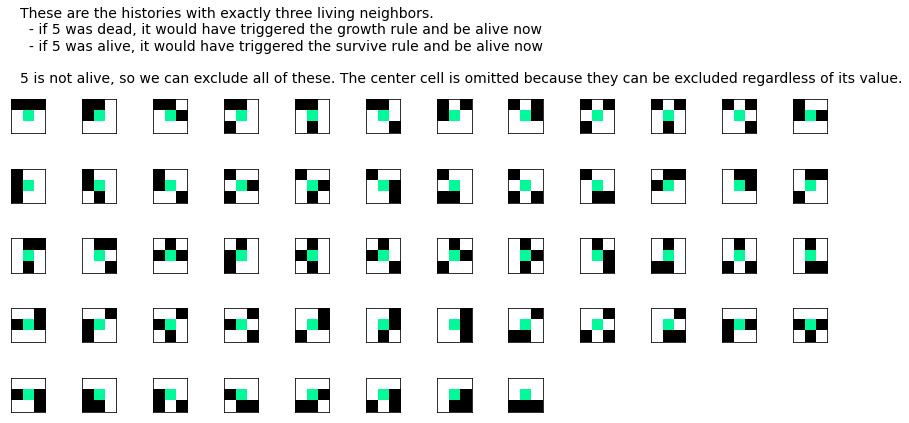

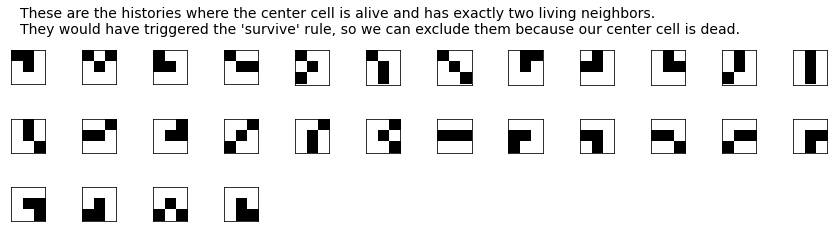

In [504]:
tell(example1, end)

Our SAT solver will consume expressions derived from these states.
As we iterate, we're compiling a list of histories that we can explicitly exclude.

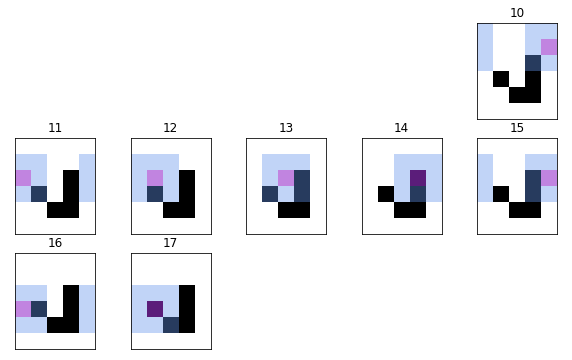

In [505]:
summarize(arc2, end)

Let's pause once more to examine the dissalowed precursor states, this time on a living node.

alive unspec (-4, -3, -2, -1)
alive dead (3, 4, 5, 6, 7, 8, 9)
alive alive (-5, 2, 3, 4, 6, 7, 8, 9)


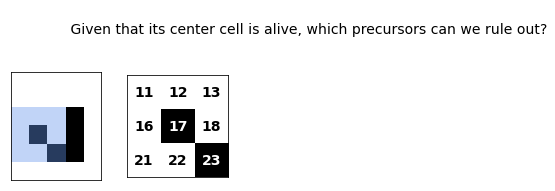

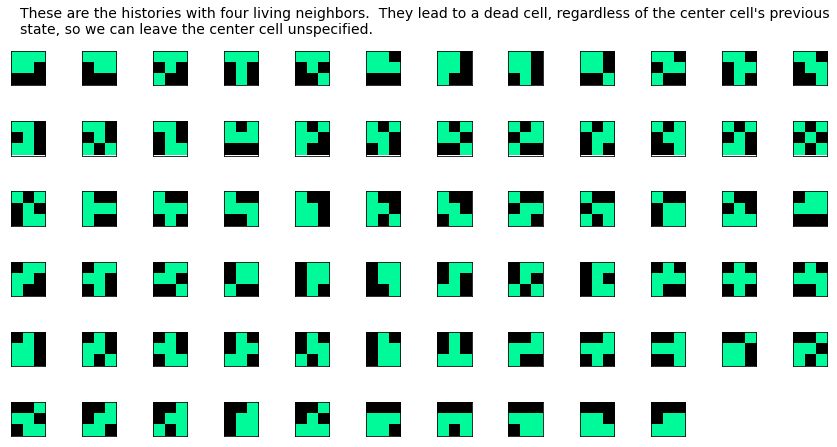

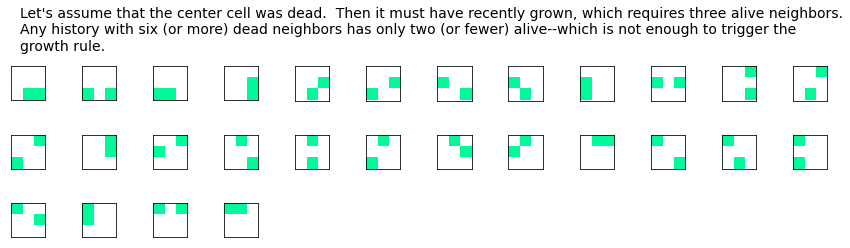

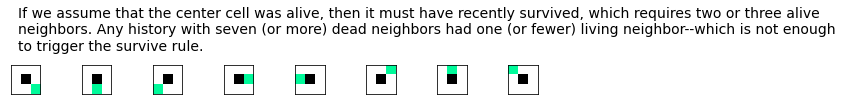

In [506]:
tell(example2, end)

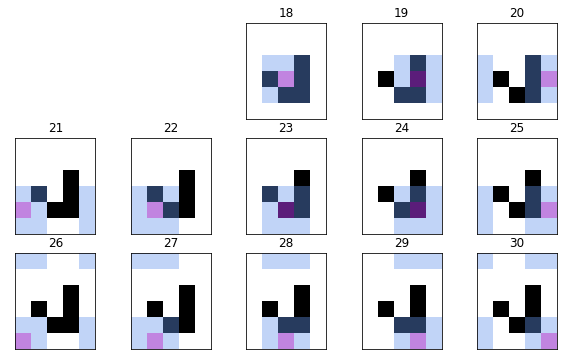

In [507]:
summarize(arc3, end)

In [508]:
all_excluded_histories = []
for arc in storyboard(end):
    for cell in arc:
        for history in get_excluded_histories(cell, end):
            all_excluded_histories.append(history)
print(f'total SAT clauses: {len(all_excluded_histories)}')

alive unspec (-4, -3, -2, -1)
alive dead (3, 4, 5, 6, 7, 8, 9)
alive alive (-5, 2, 3, 4, 6, 7, 8, 9)
alive unspec (-4, -3, -2, -1)
alive dead (3, 4, 5, 6, 7, 8, 9)
alive alive (-5, 2, 3, 4, 6, 7, 8, 9)
alive unspec (-4, -3, -2, -1)
alive dead (3, 4, 5, 6, 7, 8, 9)
alive alive (-5, 2, 3, 4, 6, 7, 8, 9)
alive unspec (-4, -3, -2, -1)
alive dead (3, 4, 5, 6, 7, 8, 9)
alive alive (-5, 2, 3, 4, 6, 7, 8, 9)
alive unspec (-4, -3, -2, -1)
alive dead (3, 4, 5, 6, 7, 8, 9)
alive alive (-5, 2, 3, 4, 6, 7, 8, 9)
total SAT clauses: 2630


In [509]:
cnf_clauses = all_excluded_histories

In [529]:
import pycosat
import random
solutions = []

for solution in pycosat.itersolve(cnf_clauses):
    solutions.append(solution)
print(len(solutions), "solutions found")

precursor_boards = []
for solution in solutions:
    slate = np.zeros(begin.shape)
    for cell in cells:
        try:
            x, y = cell_ref(abs(cell), end)
            alive = int(cell / abs(cell)) == ALIVE
            slate[y][x] =  alive
        except TypeError:
            print(cells)
    precursor_boards.append(slate)

2873 solutions found


array([[1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1]])

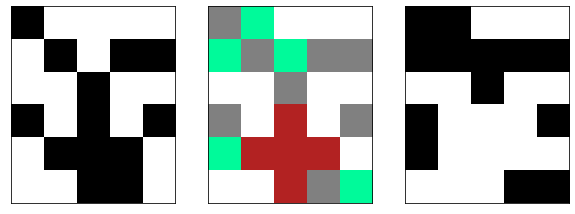

In [532]:
plotforward(precursor_boards[500])